# Dhruv Rana #

## PART 1 ##

In [1]:
import glob
import numpy as np
import pandas as pd

from numba import cuda

import tensorflow as tf
from keras.utils import load_img, img_to_array
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Using my GPU to accelrate the results

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Classify Images ####

In [2]:
# sorted alphabatically
true_label = ['vending_machine' , 'vending_machine', 'golfcart', 'golfcart' , 'otter', 'otter' , 'basketball' , 'basketball',
              'cannon','cannon']
true_label = sorted (true_label)

CLASSES = true_label[::2]

predicted_label = []

# sorted alphabatically
# place all image in data folder
images = glob.glob('data\\*.jpg')
images = sorted(images)

In [3]:
model = ResNet50(weights='imagenet')

In [4]:
for filename in images :
    img = load_img(filename, target_size=(224, 224))
    img_arr = img_to_array(img)
    img_batch = np.expand_dims(img_arr, axis=0)
    img_processed = preprocess_input(img_batch)

    prediction = model.predict(img_processed)
    prediction = np.array(decode_predictions(prediction,top=1))
        
    predicted_label.append(prediction[0,0,1])
    print('Prediction for ' + filename + ' :', prediction[0,0,1])

1/1 [==============================] - 2s 2s/step
Prediction for data\basketball1.jpg : basketball
1/1 [==============================] - 0s 22ms/step
Prediction for data\basketball2.jpg : basketball
1/1 [==============================] - 0s 19ms/step
Prediction for data\cannon1.jpg : cannon
1/1 [==============================] - 0s 18ms/step
Prediction for data\cannon2.jpg : cannon
1/1 [==============================] - 0s 19ms/step
Prediction for data\golfcart1.jpg : golfcart
1/1 [==============================] - 0s 19ms/step
Prediction for data\golfcart2.jpg : golfcart
1/1 [==============================] - 0s 20ms/step
Prediction for data\otter1.JPG : otter
1/1 [==============================] - 0s 19ms/step
Prediction for data\otter2.jpg : otter
1/1 [==============================] - 0s 19ms/step
Prediction for data\vendingmachine1.jpg : vending_machine
1/1 [==============================] - 0s 18ms/step
Prediction for data\vendingmachine2.jpg : vending_machine


#### Sklearn Results ####

In [5]:
cf_matrix = confusion_matrix(true_label,predicted_label)

df = pd.DataFrame(cf_matrix, index = CLASSES, columns=CLASSES)
print("\nConfusion Matrix :-")
print(df.to_markdown())

matrix = precision_recall_fscore_support(true_label,predicted_label,labels=CLASSES)

num_correct = [cf_matrix[i][i] for i in range(len(cf_matrix[0]))]
total_label = matrix[:][len(matrix)-1]
accuracy = num_correct / total_label * 100

df_matrix = pd.DataFrame(np.array(matrix).T[:,:-1]*100, index = CLASSES, columns = ["Precison","Recall","F-score"])

df_matrix["Accuracy"] = accuracy
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Confusion Matrix :-
|                 |   basketball |   cannon |   golfcart |   otter |   vending_machine |
|:----------------|-------------:|---------:|-----------:|--------:|------------------:|
| basketball      |            2 |        0 |          0 |       0 |                 0 |
| cannon          |            0 |        2 |          0 |       0 |                 0 |
| golfcart        |            0 |        0 |          2 |       0 |                 0 |
| otter           |            0 |        0 |          0 |       2 |                 0 |
| vending_machine |            0 |        0 |          0 |       0 |                 2 |

Performance Matrix:-
|                 |   Precison |   Recall |   F-score |   Accuracy |
|:----------------|-----------:|---------:|----------:|-----------:|
| basketball      |        100 |      100 |       100 |        100 |
| cannon          |        100 |      100 |       100 |        100 |
| golfcart        |        100 |      100 |       100 |   

In [6]:
TP = np.array([cf_matrix[i][i] for i in range(len(cf_matrix[0]))])

F = np.array([sum(cf_matrix[:,i]) for i in range(len(cf_matrix[0]))])
FP = F - TP

T = np.array([sum(cf_matrix[i,:]) for i in range(len(cf_matrix[0]))])
FN = T - TP

TN = np.array([sum(sum(cf_matrix)) for i in range(len(cf_matrix[0]))]) - TP - FP - FN


precision = TP / (FP+TP)
recall = TP / (FN+TP)
f_score = 2 * (precision*recall)/(precision+recall)
accuracy = TP / T

matrix  = [precision,recall,f_score,accuracy]

df_matrix = pd.DataFrame(np.array(matrix).T*100, index = CLASSES, columns = ["Precison","Recall","F-score","Accuracy"])
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Performance Matrix:-
|                 |   Precison |   Recall |   F-score |   Accuracy |
|:----------------|-----------:|---------:|----------:|-----------:|
| basketball      |        100 |      100 |       100 |        100 |
| cannon          |        100 |      100 |       100 |        100 |
| golfcart        |        100 |      100 |       100 |        100 |
| otter           |        100 |      100 |       100 |        100 |
| vending_machine |        100 |      100 |       100 |        100 |
| Average         |        100 |      100 |       100 |        100 |


In [7]:
del true_label
del predicted_label
del model
cuda.select_device(0)
cuda.close()

## PART 2 ##

In [8]:
import time
import copy

import numpy as np
import pandas as pd

import tensorflow as tf

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


##### Model Settings #######

In [9]:
LEARNING_RATE = 0.001

BATCH_SIZE = 128
NUM_EPOCHS = 10

NUM_INPUTS = 1*28*28 # grayscale (1-channel) 28*28 picture
NUM_CLASSES = 10 # digits 0 to 9

RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

##### Load MNIST Dataset #######

In [10]:
train_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform= transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform= transforms.ToTensor()
)

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = train_data.classes

#### Change Fully Connected Layer ####

In [11]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

print(resnet18.conv1)
print(resnet18.fc)

# we only need 10 classes need to cahnge ouput layer
# we also need to chnage so it takes 1 cahnnel instead of three channels
resnet18.fc = nn.Linear(resnet18.fc.in_features,NUM_CLASSES)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print()
print(resnet18.conv1)
print(resnet18.fc)

# Make sure to send our model to GPU if available
resnet18 = resnet18.to(DEVICE)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=10, bias=True)


#### Compare True Label w/ Predicted Label #####

In [12]:
def compute_accuracy (model, data_loader, device):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = model(inputs.to(DEVICE))
            predicted_class = torch.argmax(probabilities, dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    return num_correct_prediction/num_total_labels * 100

#### Test w/o training ####

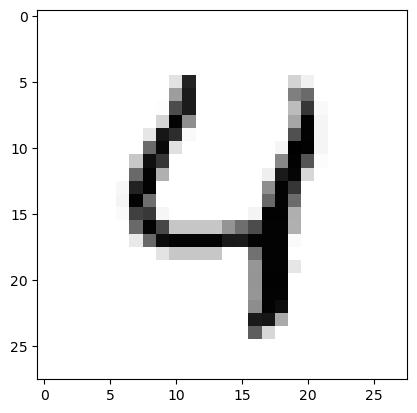

Predicted Num : 1
Actual Num : 4

Total Accuracy on test data : 11.350%


In [13]:
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    

    
img = np.transpose(inputs[4], axes=(1, 2, 0))
img = np.squeeze(img.numpy(), axis=2)
plt.imshow(img, cmap='Greys')
plt.show()



resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:d}".format(predicted_class[4]))
print("Actual Num : {:d}".format(labels[4]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))

#### Train Model ####

In [14]:
def train_model (model, data_loader, learning_rate, num_epochs, device):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)   
             
            probabilities = resnet18(inputs)
            predicted_class = torch.argmax(probabilities, dim=1)
            
            optimizer.zero_grad()
            loss = nn.functional.cross_entropy(probabilities,labels)
                
            loss.backward()
            optimizer.step()
            #scheduler.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
            
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy = compute_accuracy(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f}%".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    model.load_state_dict(best_weights)
    return model

In [15]:
resnet18 = train_model(resnet18,train_loader,LEARNING_RATE,NUM_EPOCHS,DEVICE)

EPOCH : 1/10
------------------------------
BATCH :   0/469 | LOSS : 2.423 
BATCH :  50/469 | LOSS : 1.800 
BATCH : 100/469 | LOSS : 1.570 
BATCH : 150/469 | LOSS : 1.305 
BATCH : 200/469 | LOSS : 0.942 
BATCH : 250/469 | LOSS : 0.898 
BATCH : 300/469 | LOSS : 0.597 
BATCH : 350/469 | LOSS : 0.605 
BATCH : 400/469 | LOSS : 0.529 
BATCH : 450/469 | LOSS : 0.385 

Total Accuracy On Training Data : 88.473%
Elapsed Time : 0 min 21 sec

EPOCH : 2/10
------------------------------
BATCH :   0/469 | LOSS : 0.297 
BATCH :  50/469 | LOSS : 0.407 
BATCH : 100/469 | LOSS : 0.313 
BATCH : 150/469 | LOSS : 0.398 
BATCH : 200/469 | LOSS : 0.269 
BATCH : 250/469 | LOSS : 0.245 
BATCH : 300/469 | LOSS : 0.318 
BATCH : 350/469 | LOSS : 0.284 
BATCH : 400/469 | LOSS : 0.281 
BATCH : 450/469 | LOSS : 0.214 

Total Accuracy On Training Data : 93.883%
Elapsed Time : 1 min 41 sec

EPOCH : 3/10
------------------------------
BATCH :   0/469 | LOSS : 0.255 
BATCH :  50/469 | LOSS : 0.221 
BATCH : 100/469 | LO

### Test w/ Training ###

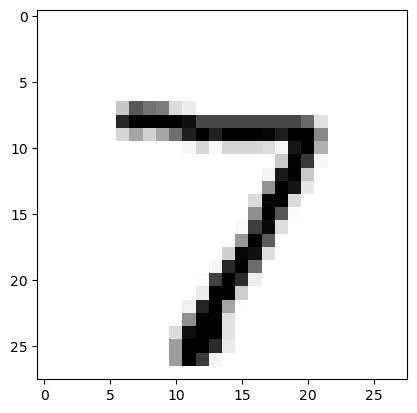

Predicted Num : 7
Actual Num : 7

Total Accuracy on test data : 97.450%


In [16]:
features = torch.empty(0)
true_label = torch.empty(0)

for batch_index, (inputs, labels) in enumerate(test_loader):

    features = torch.cat((features,inputs))
    true_label = torch.cat((true_label,labels))
    
img = np.transpose(features[0], axes=(1, 2, 0))
img = np.squeeze(img.numpy(), axis=2)
plt.imshow(img, cmap='Greys')
plt.show()


resnet18 = resnet18.eval()

with torch.no_grad():
    probabilities = resnet18(features.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:.0f}".format(predicted_class[0]))
print("Actual Num : {:.0f}".format(true_label[0]))

print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))

del features
del inputs
del labels
del probabilities

### Sklearn Results ###

In [17]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

LABELS = [0,1,2,3,4,5,6,7,8,9]

true_label = true_label.to('cpu')
predicted_label = predicted_class.to('cpu')

cf_matrix = confusion_matrix(true_label,predicted_label)

df = pd.DataFrame(cf_matrix, index = CLASSES, columns = CLASSES)
print("\nConfusion Matrix :-")
print(df.to_markdown())


matrix = precision_recall_fscore_support(true_label,predicted_label,labels=LABELS)

num_correct = [cf_matrix[i][i] for i in range(len(cf_matrix[0]))]
total_label = matrix[:][len(matrix)-1]
accuracy = num_correct / total_label * 100

df_matrix = pd.DataFrame(np.array(matrix).T[:,:-1]*100, index = CLASSES, columns = ["Precison","Recall","F-score"])

df_matrix["Accuracy"] = accuracy
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Confusion Matrix :-
|           |   0 - zero |   1 - one |   2 - two |   3 - three |   4 - four |   5 - five |   6 - six |   7 - seven |   8 - eight |   9 - nine |
|:----------|-----------:|----------:|----------:|------------:|-----------:|-----------:|----------:|------------:|------------:|-----------:|
| 0 - zero  |        969 |         0 |         0 |           0 |          0 |          1 |         4 |           2 |           3 |          1 |
| 1 - one   |          0 |      1127 |         2 |           1 |          1 |          0 |         3 |           1 |           0 |          0 |
| 2 - two   |          3 |         1 |      1008 |           5 |          0 |          0 |         1 |           8 |           6 |          0 |
| 3 - three |          0 |         0 |         5 |         986 |          0 |          8 |         0 |           3 |           6 |          2 |
| 4 - four  |          1 |         0 |         3 |           0 |        957 |          0 |         5 |           1 

### Results ###

In [18]:
TP = np.array([cf_matrix[i][i] for i in range(len(cf_matrix[0]))])

F = np.array([sum(cf_matrix[:,i]) for i in range(len(cf_matrix[0]))])
FP = F - TP

T = np.array([sum(cf_matrix[i,:]) for i in range(len(cf_matrix[0]))])
FN = T - TP

TN = np.array([sum(sum(cf_matrix)) for i in range(len(cf_matrix[0]))]) - TP - FP - FN


precision = TP / (FP+TP)
recall = TP / (FN+TP)
f_score = 2 * (precision*recall)/(precision+recall)
accuracy = TP / T

matrix  = [precision,recall,f_score,accuracy]

df_matrix = pd.DataFrame(np.array(matrix).T*100, index = CLASSES, columns = ["Precison","Recall","F-score","Accuracy"])
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Performance Matrix:-
|           |   Precison |   Recall |   F-score |   Accuracy |
|:----------|-----------:|---------:|----------:|-----------:|
| 0 - zero  |    98.3756 |  98.8776 |   98.626  |    98.8776 |
| 1 - one   |    99.4704 |  99.2952 |   99.3827 |    99.2952 |
| 2 - two   |    97.2973 |  97.6744 |   97.4855 |    97.6744 |
| 3 - three |    96.0078 |  97.6238 |   96.809  |    97.6238 |
| 4 - four  |    97.8528 |  97.4542 |   97.6531 |    97.4542 |
| 5 - five  |    97.5169 |  96.861  |   97.1879 |    96.861  |
| 6 - six   |    97.817  |  98.2255 |   98.0208 |    98.2255 |
| 7 - seven |    97.9351 |  96.8872 |   97.4083 |    96.8872 |
| 8 - eight |    95.6835 |  95.5852 |   95.6343 |    95.5852 |
| 9 - nine  |    96.3111 |  95.7384 |   96.0239 |    95.7384 |
| Average   |    97.4268 |  97.4222 |   97.4231 |    97.4222 |


In [19]:
del resnet18
del predicted_class
del true_label
del cf_matrix
del matrix
del df
del df_matrix
del test_data
del train_data
del test_loader
del train_loader
torch.cuda.empty_cache() 

## Part 3 ##

In [20]:
import os
import time
import copy

import shutil

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision import models, datasets, transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


### Model Settings ###

In [21]:
TRAIN_SPLIT = 0.7
TEST_SPLIT = 0.3

LEARNING_RATE = 0.001

BATCH_SIZE = 60
NUM_EPOCHS = 3 # Increase to improve results

NUM_CLASSES = 2 # cat or dog

RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

torch.cuda.empty_cache() 

### Sort Dataset Into Folders ###

In [22]:
# I will split the training dataset into training and test (test = 30% of training data)

base_dir = "Cat Vs Dog Dataset"
train_dir = os.path.join(base_dir,"train")

if not os.path.exists(f"{train_dir}/cat"):
        os.makedirs(f"{train_dir}/cat")
        
if not os.path.exists(f"{train_dir}/dog"):
        os.makedirs(f"{train_dir}/dog")

# Sort cats and dog in Train dir into respective folders
onlyFilesinTrain = [filename for filename in os.listdir(train_dir) if not os.path.isdir(os.path.join(train_dir,filename))]

for filename in onlyFilesinTrain:
        
        label = filename.split(".")[0]
        
        if(label == "cat"):
                shutil.move(f"{train_dir}/{filename}" , f"{train_dir}/cat/{filename}")
                
        elif(label == "dog"):
                shutil.move(f"{train_dir}/{filename}" , f"{train_dir}/dog/{filename}")
        
        else:
                print("NO Label")

### Load Data ###

In [23]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = datasets.ImageFolder(train_dir,transform=data_transform)

DATASET_SIZE = len(dataset)

train_data,test_data = random_split(dataset, [ int(TRAIN_SPLIT*DATASET_SIZE) , int(TEST_SPLIT*DATASET_SIZE)])

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = dataset.classes  

### Load ResNet18 ###

In [24]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print(resnet18.fc)

# we only need 2 classes need to cahnge ouput layer
resnet18.fc = nn.Linear(resnet18.fc.in_features,NUM_CLASSES)
print()
print(resnet18.fc)

# Make sure to send our model to GPU if available
resnet18 = resnet18.to(DEVICE)

Linear(in_features=512, out_features=1000, bias=True)

Linear(in_features=512, out_features=2, bias=True)


### Compare True Label w/ Predicted Label ###

In [25]:
def compute_accuracy (model, data_loader, device):
    
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for _ , (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels
            
            probabilities = model(inputs)
            predicted_class = torch.argmax(probabilities.cpu(), dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    torch.cuda.empty_cache()
    
    return num_correct_prediction/num_total_labels * 100

### Test ReseNet18 w/o training ###

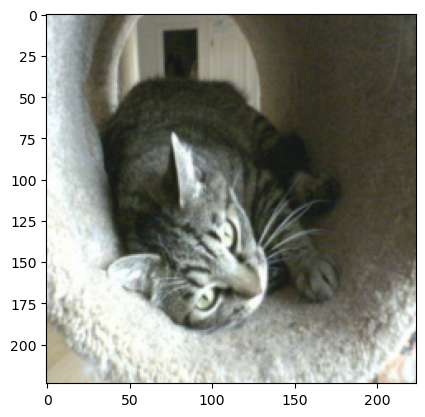

Predicted Class : dog
Actual Class : cat

Total Accuracy on test data : 60.507%


In [26]:
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    
img = torch.squeeze(inputs[0]).permute(1, 2, 0)
plt.imshow(img)
plt.show()


resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Class : {:s}".format(CLASSES[predicted_class.cpu()[0].item()]))
print("Actual Class : {:s}".format(CLASSES[labels.cpu()[0].item()]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))

torch.cuda.empty_cache() 

### Train ResNet18 ###

In [27]:
def train_model (model, data_loader, learning_rate, num_epochs, device):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)   
             
            probabilities = model(inputs)
            
            optimizer.zero_grad()
            loss = nn.functional.cross_entropy(probabilities,labels)
                
            loss.backward()
            optimizer.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
            
            #torch.cuda.empty_cache()
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy = compute_accuracy(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f}%".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    torch.cuda.empty_cache() 
    
    model.load_state_dict(best_weights)
    return model

In [28]:
resnet18 = train_model(resnet18,train_loader,LEARNING_RATE,NUM_EPOCHS,DEVICE)

EPOCH : 1/3
------------------------------
BATCH :   0/292 | LOSS : 0.652 
BATCH :  50/292 | LOSS : 0.395 
BATCH : 100/292 | LOSS : 0.260 
BATCH : 150/292 | LOSS : 0.243 
BATCH : 200/292 | LOSS : 0.145 
BATCH : 250/292 | LOSS : 0.150 

Total Accuracy On Training Data : 97.120%
Elapsed Time : 2 min 10 sec

EPOCH : 2/3
------------------------------
BATCH :   0/292 | LOSS : 0.141 
BATCH :  50/292 | LOSS : 0.114 
BATCH : 100/292 | LOSS : 0.134 
BATCH : 150/292 | LOSS : 0.115 
BATCH : 200/292 | LOSS : 0.091 
BATCH : 250/292 | LOSS : 0.103 

Total Accuracy On Training Data : 98.011%
Elapsed Time : 4 min 23 sec

EPOCH : 3/3
------------------------------
BATCH :   0/292 | LOSS : 0.084 
BATCH :  50/292 | LOSS : 0.107 
BATCH : 100/292 | LOSS : 0.144 
BATCH : 150/292 | LOSS : 0.049 
BATCH : 200/292 | LOSS : 0.086 
BATCH : 250/292 | LOSS : 0.032 

Total Accuracy On Training Data : 98.280%
Elapsed Time : 7 min 38 sec


Total Time : 7 min 38 sec


### Test ResNet18 w/ Training ###

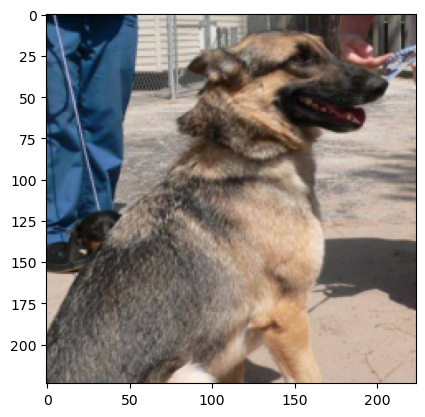

Predicted Class : dog
Actual Class : dog

Total Accuracy on test data : 98.173%


In [32]:
predicted_class_18 = torch.empty(0).to(DEVICE)
true_label_18 = torch.empty(0)

resnet18 = resnet18.eval()

for batch_index, (inputs, labels) in enumerate(test_loader):

    true_label_18 = torch.cat((true_label_18,labels))
    
    with torch.no_grad():
        probabilities = resnet18(inputs.to(DEVICE))
        predicted_class_18 = torch.cat((predicted_class_18,torch.argmax(probabilities,dim=1)))
    
    
img = torch.squeeze(inputs[10]).permute(1, 2, 0)
plt.imshow(img)
plt.show()


with torch.no_grad():
        prob = resnet18(inputs.to(DEVICE))
        pred_class = torch.argmax(prob, dim=1)

print("Predicted Class : {:s}".format(CLASSES[int(pred_class[10].item())]))
print("Actual Class : {:s}".format(CLASSES[int(labels[10].item())]))

print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))
torch.cuda.empty_cache() 

### ResNet18 Sklearn Results ###

In [33]:
LABELS = [0,1]

true_label_18 = true_label_18.to('cpu')
predicted_label_18 = predicted_class_18.to('cpu')

cf_matrix = confusion_matrix(true_label_18,predicted_label_18)

df = pd.DataFrame(cf_matrix, index = CLASSES, columns = CLASSES)

num_correct = [cf_matrix[i][i] for i in range(len(cf_matrix[0]))]

print("\nConfusion Matrix :-")
print(df.to_markdown())

matrix = precision_recall_fscore_support(true_label_18,predicted_label_18,labels=LABELS)
total_label = matrix[:][len(matrix)-1]
accuracy = num_correct / total_label * 100
df_matrix = pd.DataFrame(np.array(matrix).T[:,:-1]*100, index = CLASSES, columns = ["Precison","Recall","F-score"])
df_matrix["Accuracy"] = accuracy
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Confusion Matrix :-
|     |   cat |   dog |
|:----|------:|------:|
| cat |  3734 |    53 |
| dog |    84 |  3629 |

Performance Matrix:-
|         |   Precison |   Recall |   F-score |   Accuracy |
|:--------|-----------:|---------:|----------:|-----------:|
| cat     |    97.7999 |  98.6005 |   98.1986 |    98.6005 |
| dog     |    98.5606 |  97.7377 |   98.1474 |    97.7377 |
| Average |    98.1802 |  98.1691 |   98.173  |    98.1691 |


### ResNet18 Results ###

In [34]:
TP = np.array([cf_matrix[i][i] for i in range(len(cf_matrix[0]))])

F = np.array([sum(cf_matrix[:,i]) for i in range(len(cf_matrix[0]))])
FP = F - TP

T = np.array([sum(cf_matrix[i,:]) for i in range(len(cf_matrix[0]))])
FN = T - TP

TN = np.array([sum(sum(cf_matrix)) for i in range(len(cf_matrix[0]))]) - TP - FP - FN


precision = TP / (FP+TP)
recall = TP / (FN+TP)
f_score = 2 * (precision*recall)/(precision+recall)
accuracy = TP / T

matrix  = [precision,recall,f_score,accuracy]

df_matrix = pd.DataFrame(np.array(matrix).T*100, index = CLASSES, columns = ["Precison","Recall","F-score","Accuracy"])
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Performance Matrix:-
|         |   Precison |   Recall |   F-score |   Accuracy |
|:--------|-----------:|---------:|----------:|-----------:|
| cat     |    97.7999 |  98.6005 |   98.1986 |    98.6005 |
| dog     |    98.5606 |  97.7377 |   98.1474 |    97.7377 |
| Average |    98.1802 |  98.1691 |   98.173  |    98.1691 |


In [35]:
del resnet18
del predicted_class_18
del true_label_18
del df
del df_matrix
torch.cuda.empty_cache() 

### Load ResNet50 ###

In [36]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(resnet50.fc)

# we only need 2 classes need to cahnge ouput layer
resnet50.fc = nn.Linear(resnet50.fc.in_features,NUM_CLASSES)
print()
print(resnet50.fc)

# Make sure to send our model to GPU if available
resnet50 = resnet50.to(DEVICE)

Linear(in_features=2048, out_features=1000, bias=True)

Linear(in_features=2048, out_features=2, bias=True)


### Test ReseNet50 w/o training ###

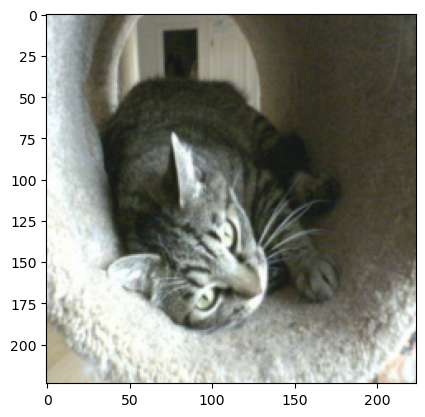

Predicted Class : dog
Actual Class : cat

Total Accuracy on test data : 26.547%


In [37]:
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    
img = torch.squeeze(inputs[0]).permute(1, 2, 0)
plt.imshow(img)
plt.show()


resnet50 = resnet50.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet50(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Class : {:s}".format(CLASSES[predicted_class.cpu()[0].item()]))
print("Actual Class : {:s}".format(CLASSES[labels.cpu()[0].item()]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet50,test_loader,DEVICE)))

torch.cuda.empty_cache() 

### Train ResNet50 ###

In [ ]:
NUM_EPOCHS = 3

In [38]:
resnet50 = train_model(resnet50,train_loader,LEARNING_RATE,NUM_EPOCHS,DEVICE)

EPOCH : 1/3
------------------------------
BATCH :   0/292 | LOSS : 0.726 
BATCH :  50/292 | LOSS : 0.567 
BATCH : 100/292 | LOSS : 0.496 
BATCH : 150/292 | LOSS : 0.390 
BATCH : 200/292 | LOSS : 0.353 
BATCH : 250/292 | LOSS : 0.280 

Total Accuracy On Training Data : 97.040%
Elapsed Time : 5 min 38 sec

EPOCH : 2/3
------------------------------
BATCH :   0/292 | LOSS : 0.243 
BATCH :  50/292 | LOSS : 0.257 
BATCH : 100/292 | LOSS : 0.258 
BATCH : 150/292 | LOSS : 0.228 
BATCH : 200/292 | LOSS : 0.168 
BATCH : 250/292 | LOSS : 0.195 

Total Accuracy On Training Data : 97.977%
Elapsed Time : 9 min 19 sec

EPOCH : 3/3
------------------------------
BATCH :   0/292 | LOSS : 0.153 
BATCH :  50/292 | LOSS : 0.129 
BATCH : 100/292 | LOSS : 0.203 
BATCH : 150/292 | LOSS : 0.159 
BATCH : 200/292 | LOSS : 0.157 
BATCH : 250/292 | LOSS : 0.160 

Total Accuracy On Training Data : 98.429%
Elapsed Time : 14 min 3 sec


Total Time : 14 min 3 sec


### Test ResNet50 w/ Training ###

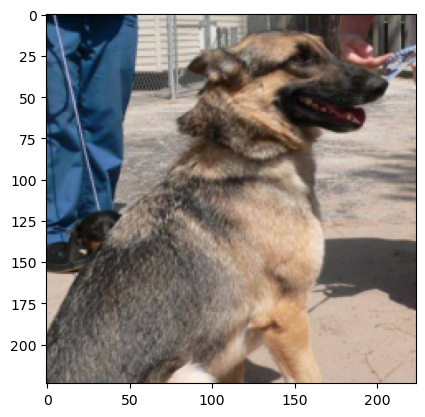

Predicted Class : dog
Actual Class : dog

Total Accuracy on test data : 98.133%


In [39]:
predicted_class_50 = torch.empty(0).to(DEVICE)
true_label_50 = torch.empty(0)

resnet50 = resnet50.eval()

for batch_index, (inputs, labels) in enumerate(test_loader):

    true_label_50 = torch.cat((true_label_50,labels))
    
    with torch.no_grad():
        probabilities = resnet50(inputs.to(DEVICE))
        predicted_class_50 = torch.cat((predicted_class_50,torch.argmax(probabilities,dim=1)))
    
    
img = torch.squeeze(inputs[10]).permute(1, 2, 0)
plt.imshow(img)
plt.show()


with torch.no_grad():
        prob = resnet50(inputs.to(DEVICE))
        pred_class = torch.argmax(prob, dim=1)

print("Predicted Class : {:s}".format(CLASSES[int(pred_class[10].item())]))
print("Actual Class : {:s}".format(CLASSES[int(labels[10].item())]))

print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet50,test_loader,DEVICE)))
torch.cuda.empty_cache() 

### ResNet50 Sklearn Result ###

In [44]:
LABELS = [0,1]

true_label_50 = true_label_50.to('cpu')
predicted_label_50 = predicted_class_50.to('cpu')

cf_matrix = confusion_matrix(true_label_50,predicted_label_50)

df = pd.DataFrame(cf_matrix, index = CLASSES, columns = CLASSES)

num_correct = [cf_matrix[i][i] for i in range(len(cf_matrix[0]))]

print("\nConfusion Matrix :-")
print(df.to_markdown())

matrix = precision_recall_fscore_support(true_label_50,predicted_label_50,labels=LABELS)
total_label = matrix[:][len(matrix)-1]
accuracy = num_correct / total_label * 100
df_matrix = pd.DataFrame(np.array(matrix).T[:,:-1]*100, index = CLASSES, columns = ["Precison","Recall","F-score"])
df_matrix["Accuracy"] = accuracy
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Confusion Matrix :-
|     |   cat |   dog |
|:----|------:|------:|
| cat |  3748 |    39 |
| dog |   101 |  3612 |

Performance Matrix:-
|         |   Precison |   Recall |   F-score |   Accuracy |
|:--------|-----------:|---------:|----------:|-----------:|
| cat     |    97.3759 |  98.9702 |   98.1666 |    98.9702 |
| dog     |    98.9318 |  97.2798 |   98.0989 |    97.2798 |
| Average |    98.1539 |  98.125  |   98.1327 |    98.125  |


### ResNet50 Results ###

In [45]:
TP = np.array([cf_matrix[i][i] for i in range(len(cf_matrix[0]))])

F = np.array([sum(cf_matrix[:,i]) for i in range(len(cf_matrix[0]))])
FP = F - TP

T = np.array([sum(cf_matrix[i,:]) for i in range(len(cf_matrix[0]))])
FN = T - TP

TN = np.array([sum(sum(cf_matrix)) for i in range(len(cf_matrix[0]))]) - TP - FP - FN


precision = TP / (FP+TP)
recall = TP / (FN+TP)
f_score = 2 * (precision*recall)/(precision+recall)
accuracy = TP / T

matrix  = [precision,recall,f_score,accuracy]

df_matrix = pd.DataFrame(np.array(matrix).T*100, index = CLASSES, columns = ["Precison","Recall","F-score","Accuracy"])
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Performance Matrix:-
|         |   Precison |   Recall |   F-score |   Accuracy |
|:--------|-----------:|---------:|----------:|-----------:|
| cat     |    97.3759 |  98.9702 |   98.1666 |    98.9702 |
| dog     |    98.9318 |  97.2798 |   98.0989 |    97.2798 |
| Average |    98.1539 |  98.125  |   98.1327 |    98.125  |
